In [ ]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

from model import Model
import utils
from early_stopping import EarlyStopping
from decoder import LinearAccDecoder
from gp import moving_average

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
config = utils.read_config()
# set seeds
utils.set_seeds(config['seed'])
# utils.set_seeds(7)

In [ ]:
behaviour_data, spikes = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data, spikes = [x[time_from:, :] for x in behaviour_data], [x[time_from:, :] for x in spikes]
num_trials, time_bins, emissions_dim = np.array(spikes).shape

In [ ]:
stim_idx, choice_idx = 6, 3
stim = [x[0, stim_idx] for x in behaviour_data]
choice = [x[0, choice_idx] for x in behaviour_data]
num_contacts = [np.sum(x[:, -9:-5], axis=1) for x in behaviour_data]
# concat them
behaviour_data = np.stack((stim, choice), axis=1)

In [ ]:
# convert to torch tensors
behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = torch.tensor(spikes, dtype=torch.float32)

In [ ]:
# create dataloader with random sampling for training and testing
# split data into training and testing
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)

# create dataloaders
train_dataset = TensorDataset(behaviour_data_train, spikes_train)
test_dataset = TensorDataset(behaviour_data_test, spikes_test)

batch_size = config['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_train[:, 0].numpy()), np.mean(behaviour_data_train[:, 1].numpy())))
print("Test distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_test[:, 0].numpy()), np.mean(behaviour_data_test[:, 1].numpy())))

In [ ]:
# mean firing rate of neurons in tran spikes
neuron_bias = torch.mean(spikes_train, dim=0)

In [ ]:
# # check if mps is available
# device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
# print(device)
# model = model.to(device)
# spikes = spikes.to(device)

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for _, (behavior_batch, spikes_batch) in enumerate(test_loader):
            y_recon, (mu, A), (z, x), behavior_batch_pred = model(spikes_batch)
            _, loss_l = model.loss(100, spikes_batch, y_recon, mu, A, z, x, behavior_batch_pred, behavior_batch)
            test_loss += np.array(loss_l)
    # divide loss by total number of samples in dataloader    
    return test_loss/len(test_loader)

In [114]:
config = utils.read_config()
# training loop
num_epochs = config['epochs']
# create model and optimizer
model = Model(config, input_dim=emissions_dim) #, neuron_bias=neuron_bias
early_stop = EarlyStopping(patience=config['early_stop']['patience'], delta=config['early_stop']['delta'], trace_func=print)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=1, verbose=True, patience=5, factor=0.5)
# print named parameters of model
# print("Model's state_dict:")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)

Number of trainable parameters in VAE: 14688
Number of trainable parameters in behavior decoder: 441


In [115]:
torch.autograd.set_detect_anomaly(True)
train_losses, test_losses = [], []
def train(model, val_loader):    
    test_every = config['test_every']    
    save_model = True
    for epoch in range(num_epochs):
        # forward pass
        print(model.behavior_decoder.scheduler.get_last_lr())
        epoch_loss = 0
        model.train()
        for i, (behavior_batch, spikes_batch) in enumerate(train_loader):            
            y_recon, (mu, A), (z, x), behavior_pred = model(spikes_batch)
            loss, loss_l = model.loss(epoch, spikes_batch, y_recon, mu, A, z, x, behavior_pred, behavior_batch)            
            # backward pass
            model.optim_zero_grad()
            loss.backward()
            model.optim_step()
            model.scheduler_step()
            epoch_loss += np.array(loss_l)
        train_losses.append((epoch, epoch_loss/len(train_loader)))
        # test loss
        if (epoch+1) % test_every == 0:            
            test_loss = test(model, val_loader)
            sum_test_loss = np.sum(test_loss)
            # scheduler.step(sum_test_loss)
            test_losses.append((epoch, test_loss))
            early_stop(sum_test_loss, model, save_model=save_model, save_prefix='best')
            print('Epoch [{}/{}], Train Loss: {}, Test Loss: {}, Best Loss: {}'.format(epoch+1, num_epochs, train_losses[-1][1], test_losses[-1][1], early_stop.best_score))
            if early_stop.slow_down:
                test_every = config['early_stop']['test_every_new']
            else:
                test_every = config['test_every']
            if early_stop.early_stop:
                print("Early stopping")
                break
            
    
    only_test_loss = [np.sum(x[1]) for x in test_losses]
    
    # compute min test loss and return it    
    # return np.min(only_test_loss), train_losses, test_losses
    
    # compute median of test loss in a window of 5
    meds = []
    half_window = 10
    only_test_loss = [0]*(half_window) + only_test_loss + [0]*(half_window)
    for i in range(half_window, len(only_test_loss)-half_window):
        meds.append(np.max(only_test_loss[i-half_window:i+half_window]))
    return np.min(meds), train_losses, test_losses

_ = train(model, test_loader)
# train model
# min_test_loss, train_losses, test_losses = train(model, test_loader)

[0.1]
[0.09990133642141358]
[0.0996057350657239]
[0.09911436253643445]
[0.09842915805643156]
[0.09755282581475769]
[0.09648882429441258]
[0.09524135262330098]
[0.09381533400219318]
[0.09221639627510075]
[0.09045084971874738]
[0.08852566213878947]
[0.08644843137107058]
[0.08422735529643444]
[0.08187119948743449]
[0.07938926261462367]
[0.07679133974894983]
[0.07408768370508577]
[0.07128896457825364]
[0.06840622763423392]
Epoch [20/2000], Train Loss: [696.43185425  13.48294544], Test Loss: [691.84332275  11.88124752], Best Loss: 703.724570274353
[0.06545084971874737]
[0.062434494358242734]
[0.05936906572928624]
[0.05626666167821523]
[0.05313952597646568]
[0.05]
[0.04686047402353433]
[0.0437333383217848]
[0.04063093427071377]
[0.03756550564175726]
[0.03454915028125264]
[0.03159377236576612]
[0.028711035421746363]
[0.02591231629491423]
[0.023208660251050162]
[0.02061073738537635]
[0.01812880051256552]
[0.015772644703565566]
[0.013551568628929435]
[0.011474337861210543]
Saved best
Epoch [40/

KeyboardInterrupt: 

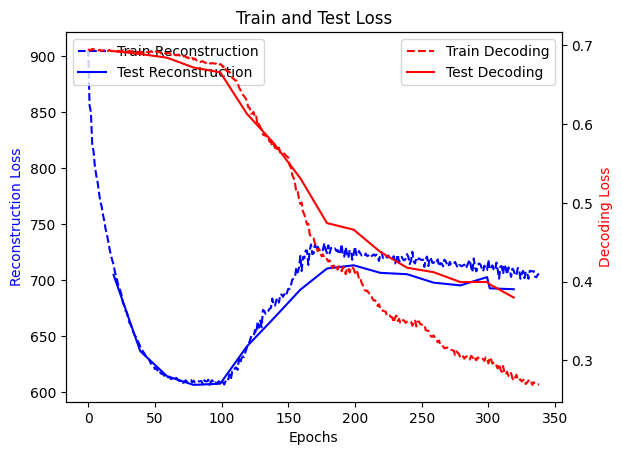

In [107]:
utils.plot_curve(model, config, train_losses, test_losses)

In [108]:
# load best model
model.load_model('best')

Loaded model


In [ ]:
lin_maps = model.vae.linear_maps
# c1, c2 = lin_maps[0].weight.detach().numpy(), lin_maps[1].weight.detach().numpy()
# print(c1.T.dot(c2)/(np.linalg.norm(c1)*np.linalg.norm(c2)))
c1, c2, c3 = lin_maps[0].weight.detach().numpy(), lin_maps[1].weight.detach().numpy(), lin_maps[2].weight.detach().numpy()
print("Norms: {}, {}, {}".format(np.linalg.norm(c1), np.linalg.norm(c2), np.linalg.norm(c3)))

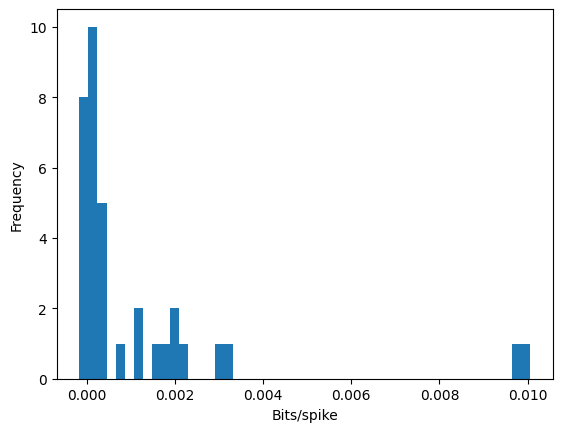

Bits per spike all: 0.04070143401622772, test: 0.036302682012319565


In [109]:
with torch.no_grad():
    model.eval()
    y_recon, (mu, A), _, _ = model.forward(spikes)    
    # run on only test
    y_recon_test, (mu_test, A_test), _, _ = model.forward(spikes_test)
    
# convert to numpy
y_recon_np = y_recon.detach().numpy()
spikes_np = spikes.detach().numpy()
y_recon_test_np = y_recon_test.detach().numpy()
spikes_test_np = spikes_test.detach().numpy()
# compute bits/spike
bits_per_spike_all = utils.bits_per_spike(y_recon_np, spikes_np)
bits_per_spike_test = utils.bits_per_spike(y_recon_test_np, spikes_test_np)
# show distribution of bits per spike
plt.hist(bits_per_spike_all, bins=50)
plt.xlabel('Bits/spike')
plt.ylabel('Frequency')
plt.show()
# print('Bits per spike: {}'.format(bits_per_spike))
print("Bits per spike all: {}, test: {}".format(np.sum(bits_per_spike_all), np.sum(bits_per_spike_test)))

In [ ]:
a_t = np.mean(A.numpy()[:, 10, :, :], axis=0)
cov = a_t * a_t.T
# print(cov.shape, spikes_np.shape)
plt.imshow(cov)
plt.colorbar()

In [ ]:
# plot PSTH of reconstructed and original data
averaged_recon, averaged_original = y_recon.mean(axis=0), spikes_np.mean(axis=0)
# stimulus and choice important
common = [12, 14, 4, 31]
stim_neurons = [15, 11, 33, 30]
choice_neurons = [16, 2, 6, 8]
# plot each in a 5x7 grid
fig, axs = plt.subplots(5, 7, figsize=(12, 9))
# set title of figure
fig.suptitle('yellow: choice, green: stimulus, pink: common')
for i in range(5):
    for j in range(7):
        neuron_idx = i*7+j        
        axs[i, j].plot(averaged_recon[:, neuron_idx], label='recon', color='red')
        axs[i, j].plot(averaged_original[:, neuron_idx], label='original', color='blue')
        # no ticks
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        # set title of plot to neuron index
        # print only 2 decimal places        
        axs[i, j].set_title('{}: {:.4f}'.format(neuron_idx, bits_per_spike_all[neuron_idx]))
        # set background color of plot to green if neuron in choice
        if neuron_idx in choice_neurons:
            axs[i, j].set_facecolor('yellow')
        # set background color of plot to red if neuron in stimulus
        if neuron_idx in stim_neurons:
            axs[i, j].set_facecolor('green')
        # set background color of plot to blue if neuron in common
        if neuron_idx in common:
            axs[i, j].set_facecolor('pink')
axs[0, 0].legend()

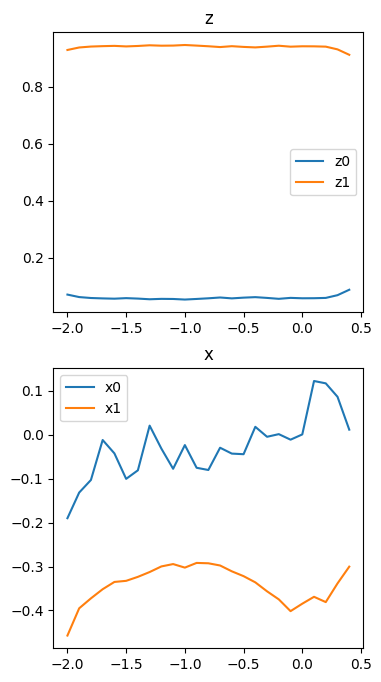

In [110]:
# plot trial averaged latent space
z, x = torch.nn.Softmax(dim=2)(mu[:, :, :model.vae.z_dim]).numpy(), mu[:, :, model.vae.z_dim:].numpy()
# z_std, x_std = np.std(z, axis=0), np.std(x, axis=0)
fig, axs = plt.subplots(2, 1, figsize=(4, 8))
z_avg, x_avg = np.mean(z, axis=0), np.mean(x, axis=0)
# make x ticks of range 0.1 from -2 to 0.5
bin_len = config['shape_dataset']['win_len']
t = np.arange(-2, 0.5, bin_len)
for i in range(z.shape[2]):
    axs[0].plot(t, z_avg[:, i], label='z{}'.format(i))
    axs[1].plot(t, x_avg[:, i], label='x{}'.format(i))
axs[0].set_title('z')
axs[1].set_title('x')
axs[0].legend()
axs[1].legend()

In [ ]:
print(model.arch_name)

In [ ]:
def plot_cont_latent(data, label, ax_id, linestyle):
    num_latents = data.shape[1]
    for i in range(num_latents):
        axs[ax_id].plot(t, data[:, i], label='{}_x{}'.format(label, i),
                        color=colors[i], linestyle=linestyle)    
        
colors = ['red', 'blue', 'green', 'yellow']
# group x for stimulus and choice
stim, choice = behaviour_data[:, 0].numpy(), behaviour_data[:, 1].numpy()
# group x for stimulus
x_stim_left, x_stim_right = x[stim == 1].mean(axis=0), x[stim == 0].mean(axis=0)
x_choice_left, x_choice_right = x[choice == 1].mean(axis=0), x[choice == 0].mean(axis=0)
# plot x for stimulus and choice
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_cont_latent(x_stim_left, 'stim left', 0, '-')
plot_cont_latent(x_stim_right, 'stim right', 0, '-.')
axs[0].set_title('x grouped by stimulus')
axs[0].legend()

plot_cont_latent(x_choice_left, 'choice left', 1, '-')
plot_cont_latent(x_choice_right, 'choice right', 1, '-.')
axs[1].set_title('x grouped by choice')
axs[1].legend()


In [79]:
with torch.no_grad():
    model.eval()    
    _, (mu_train, A_train), (z_train, x_train), behavior_pred_train = model.forward(spikes_train)
    _, (mu_test, A_test), (z_test, x_test), behavior_pred_test = model.forward(spikes_test)
# if behavior_pred_train is None:
# train the linear decoder for behavior
# create linear decoder
linear_decoder = LinearAccDecoder(config, input_dim=2)
optimizer = torch.optim.Adam(linear_decoder.parameters(), lr=0.01)
decoder_train_l, decoder_test_l = [], []
for epoch in range(10):
    linear_decoder.train()
    # forward pass        
    linear_decoder.train()
    behavior_pred = linear_decoder(x_train, z_train)
    # behavior_pred = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
    loss = linear_decoder.loss(behavior_pred, behaviour_data_train, None)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    
    epoch_loss = loss.item()    
    decoder_train_l.append(epoch_loss)
    # test loss
    if (epoch+1) % 1 == 0:
        linear_decoder.eval()
        test_pred = linear_decoder(x_test, z_test)
        # behavior_pred = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
        test_loss = linear_decoder.loss(test_pred, behaviour_data_test, None).item()        
        decoder_test_l.append(test_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, decoder_train_l[-1], decoder_test_l[-1]))
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), os.path.join(base_path, 'vae_model_{}.pt'.format(epoch)))
    #     print('Model saved at epoch {}'.format(epoch))
with torch.no_grad():
    behavior_pred_train = linear_decoder(x_train, z_train).detach()
    behavior_pred_test = linear_decoder(x_test, z_test).detach()
    # behavior_pred_train = linear_decoder(mu_train[:, :, :2], mu_train[:, :, 2:])
    # behavior_pred_test = linear_decoder(mu_test[:, :, :2], mu_test[:, :, 2:])

KeyError: 'linear'

In [111]:
num_samples = 100
agg_pred_train, agg_pred_test = [], []
agg_y_train, agg_y_test = [], []

# convert to numpy
y_train = behaviour_data_train.numpy()
y_test = behaviour_data_test.numpy()
# accuracy of stimulus and choice
acc_stim_train, acc_stim_test = [], []
acc_choice_train, acc_choice_test = [], []

with torch.no_grad():
    model.eval()
    for _ in range(num_samples):
        _, (mu_train, A_train), (z_train, x_train), behavior_pred_train = model.forward(spikes_train)
        _, (mu_test, A_test), (z_test, x_test), behavior_pred_test = model.forward(spikes_test)    
        # convert to numpy
        pred_train = behavior_pred_train.numpy() > 0
        pred_test = behavior_pred_test.numpy() > 0
        # compute accuracy
        # print(behaviour_data_train.numpy()[:, 0])
        accuracy_train_stim = accuracy_score(y_train[:, 0], pred_train[:, 0])
        accuracy_test_stim = accuracy_score(y_test[:, 0], pred_test[:, 0])        
        # do the same for choice
        accuracy_train_choice = accuracy_score(y_train[:, 1], pred_train[:, 1])
        accuracy_test_choice = accuracy_score(y_test[:, 1], pred_test[:, 1])
        # append to list
        acc_stim_train.append(accuracy_train_stim)
        acc_stim_test.append(accuracy_test_stim)
        acc_choice_train.append(accuracy_train_choice)
        acc_choice_test.append(accuracy_test_choice)
# print accuracy
print('Stimulus Accuracy - train: {:.4f} +- {:.4f}, test: {:.4f} +- {:.4f}'.format(np.mean(acc_stim_train), np.std(acc_stim_train), np.mean(acc_stim_test), np.std(acc_stim_test)))
print('Choice Accuracy - train: {:.4f} +- {:.4f}, test: {:.4f} +- {:.4f}'.format(np.mean(acc_choice_train), np.std(acc_choice_train), np.mean(acc_choice_test), np.std(acc_choice_test)))

Stimulus Accuracy - train: 0.4873 +- 0.0274, test: 0.5227 +- 0.0496
Choice Accuracy - train: 1.0000 +- 0.0000, test: 0.8980 +- 0.0000


In [ ]:
# examine a random trial
trial_idx = np.random.randint(num_trials)
# plot z and x
fig, axs = plt.subplots(3, 1, figsize=(5, 8))
# plot z
bin_len = config['shape_dataset']['win_len']
t = np.arange(-2, 0.5, bin_len)
axs[0].plot(t, z[trial_idx, :, 0], label='z0')
axs[0].plot(t, z[trial_idx, :, 1], label='z1')
# axs[0].plot(t, z[trial_idx, :, 2], label='z2')
axs[0].set_title('z')
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].set_xticks([])
# plot num contacts
axs[1].plot(t, num_contacts[trial_idx])
axs[1].set_title('num contacts')
axs[1].set_xticks([])
# plot x
axs[2].plot(t, x[trial_idx, :, 0], label='x0')
axs[2].plot(t, x[trial_idx, :, 1], label='x1')
# axs[2].plot(t, x[trial_idx, :, 2], label='x2')
axs[2].set_title('x, stimulus: {}, choice: {}'.format(stim[trial_idx].astype(int), choice[trial_idx].astype(int)))
axs[2].set_ylim(-2, 2)
axs[2].legend()

In [ ]:
# train a sklearn logistic regression model for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def reshape(x, y):
    trials, time, dim = x.shape
    # x = x[:, -5:-4, :]
    return x.reshape(trials, -1), y

stim_choice = 1

x_train_baseline, y_train_baseline = reshape(spikes_train, behaviour_data_train)
x_test_baseline, y_test_baseline = reshape(spikes_test, behaviour_data_test)
# train logistic regression model
log_reg = LogisticRegression(penalty='l1', C=1, solver='liblinear', verbose=1)
# log_reg = SVC()
log_reg.fit(x_train_baseline, y_train_baseline[:, stim_choice])
# test accuracy
accuracy_train = accuracy_score(y_train_baseline[:, stim_choice], log_reg.predict(x_train_baseline))
accuracy_test = accuracy_score(y_test_baseline[:, stim_choice], log_reg.predict(x_test_baseline))
print('Logistic Regression Accuracy - train: {:.4f}, test: {:.4f}'.format(accuracy_train, accuracy_test))

In [ ]:
# plot coefficients in a 2d grid
c = log_reg.coef_.reshape(-1, 25)
plt.imshow(c)